In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

# Load the data
data = pd.read_csv('../notebooks/data/merged_data.csv')

print(f'dataframe shape: {data.shape}')

dataframe shape: (1305, 344)


## Identify weeks where patient tests are missing
Each week urine is tested for 9 different drug classes.  If all 9 drug tests are missing, patient is considered no show

In [2]:
# create 24 dataframes, for each week of treatment
for i in range(1, 25):
    # name each dataframe week+number (week of treatment), including all 
    globals()[f'week_{i}'] = data[['patdeid']+[col for col in data.columns if col.startswith('test') and col.endswith(f'_{i}')]]
    
    # create a new column 'no_show_{i}' for each week, count all the nans, if count equals 9 then 1 for no show, else 0
    globals()[f'week_{i}'][f'missed_tests{i}'] = np.where(globals()[f'week_{i}'].isna().sum(axis=1) == 9, 1, 0)

    # merge all dfs together
    if i == 1:
        merged = globals()[f'week_{i}'] # add the first week of clinical data to merged dataframe
    else:
        merged = pd.merge(merged, globals()[f'week_{i}'], on='patdeid', how='left') # use left merge to preserve patdeid as key column

# drop columns except for no_show_{i}, keep patdeid as primary key
merged = merged[['patdeid']+[col for col in merged.columns if 'missed_tests' in col]] 

# rename columns for easier reading
merged.columns = merged.columns.str.replace('missed_tests', '')

# sum all the no_show_{i} columns to get the total no shows
merged['missed_tests'] = merged.iloc[:, 1:].sum(axis=1)

# add medication column to merged dataframe
merged['meds'] = data['medication']

merged

,patdeid,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,missed_tests,meds
0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,2,2.0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
3,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,2.0
4,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,24,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,1922,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.0
1301,1923,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,13,2.0
1302,1925,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,7,1.0
1303,1929,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,9,1.0


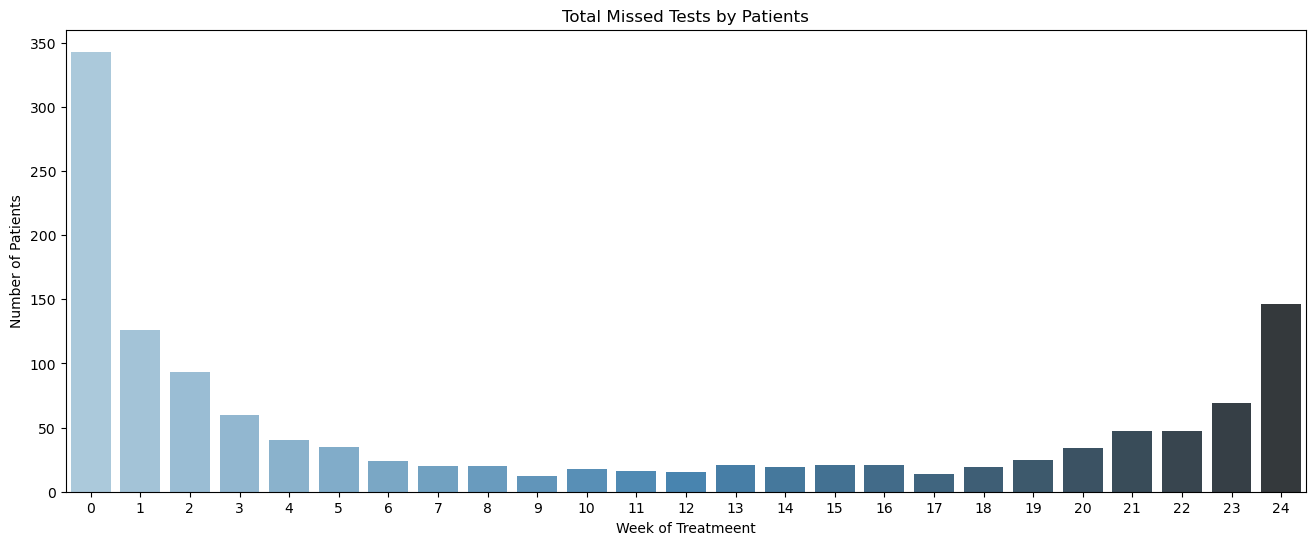

In [3]:
# plot the total missed tests by patients
missed_tests = merged.missed_tests.value_counts().sort_index(ascending=True)

fig = plt.figure(figsize=(16, 6))
ax = sns.countplot(x='missed_tests', data=merged, palette='Blues_d')
ax.set_title('Total Missed Tests by Patients')
ax.set_xlabel('Week of Treatmeent')
ax.set_ylabel('Number of Patients')

# Rotate the X-axis labels to the normal position
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show();

In [5]:
# create table with count of missed tests and rate of missed tests by drug class
meds = merged.groupby('meds').agg(
                                total_patients=('patdeid', 'nunique'),
                                missed_tests=('missed_tests', 'sum')
                                ).reset_index()

# create rate column
meds['rate'] = np.nan

# calculate percent of missed tests by medication class
for i in range(len(meds)):
    meds['rate'][i] = meds['missed_tests'][i] / meds['missed_tests'].sum().round(2)

# round the rate column to 2 decimal places
meds['rate'] = meds['rate'].round(2)

# update row values for interpretability
meds['meds'] = meds['meds'].replace({1.0: 'methadone', 2.0: 'buprenorphine'})

meds

,meds,total_patients,missed_tests,rate
0,methadone,543,3284,0.27
1,buprenorphine,762,8668,0.73


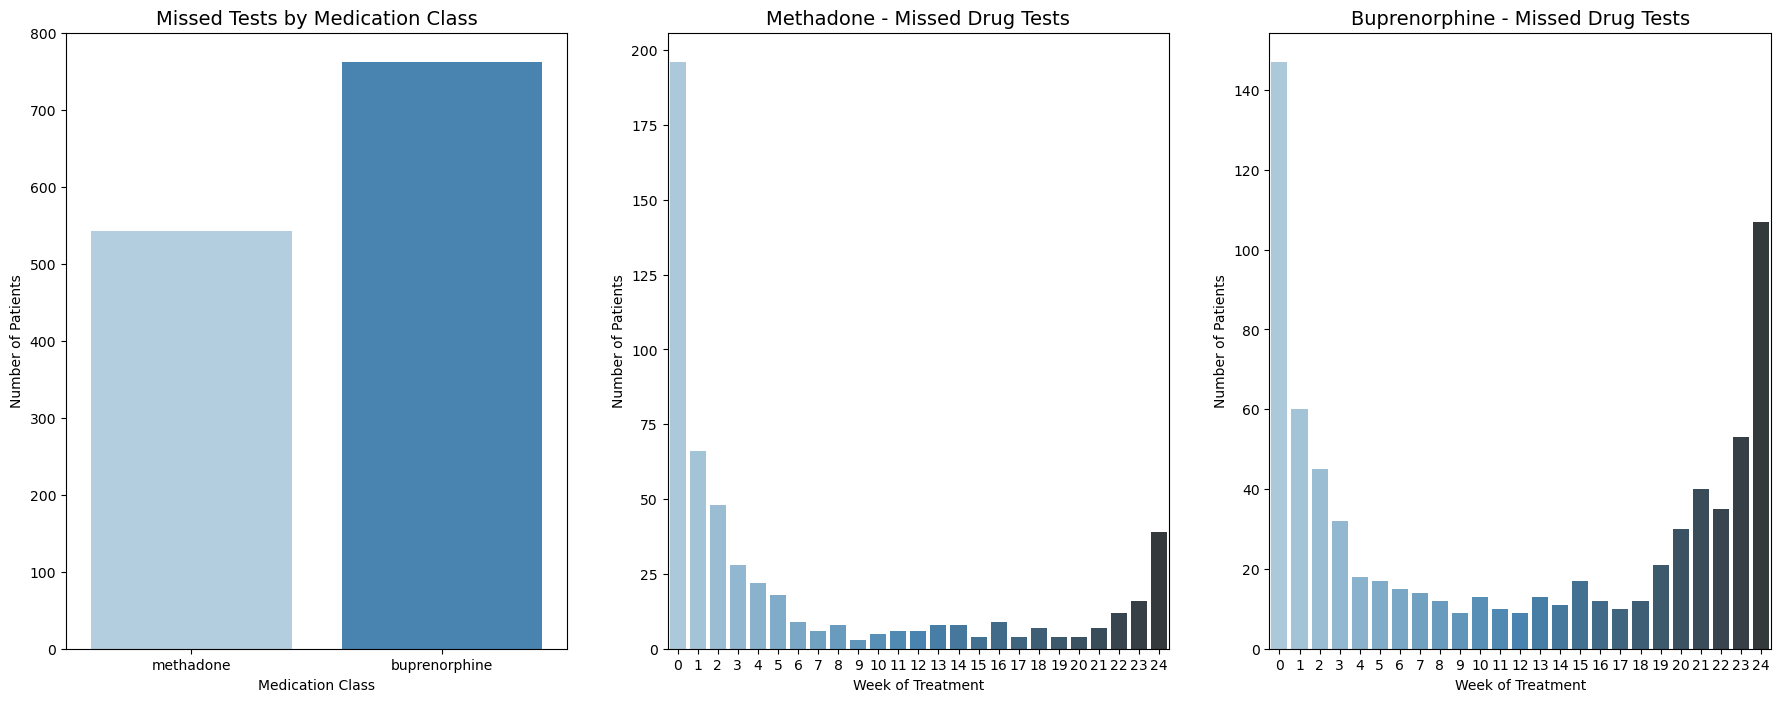

In [9]:
# create a new dataframe for each medication group
med1 = merged[merged['meds'] == 1]
med2 = merged[merged['meds'] == 2]

# create three plots next to each other
fig, axes = plt.subplots(1, 3, figsize=(22, 8))

# plot no shows by medication
sns.countplot(x='meds', data=merged, ax=axes[0], palette='Blues')
axes[0].set_title('Missed Tests by Medication Class' , fontsize=14)
axes[0].set_xlabel('Medication Class')
axes[0].set_ylabel('Number of Patients')

# plot no shows by medication by week
sns.countplot(x='missed_tests', data=med1, ax=axes[1], palette='Blues_d')
axes[1].set_title('Methadone - Missed Drug Tests', fontsize=14)
axes[1].set_xlabel('Week of Treatment')
axes[1].set_ylabel('Number of Patients')

# plot no shows by medication by week
sns.countplot(x='missed_tests', data=med2, ax=axes[2], palette='Blues_d')
axes[2].set_title('Buprenorphine - Missed Drug Tests', fontsize=14)
axes[2].set_xlabel('Week of Treatment')
axes[2].set_ylabel('Number of Patients')

# Rename the 'meds' classes
axes[0].set_xticklabels(['methadone', 'buprenorphine'])
plt.show()


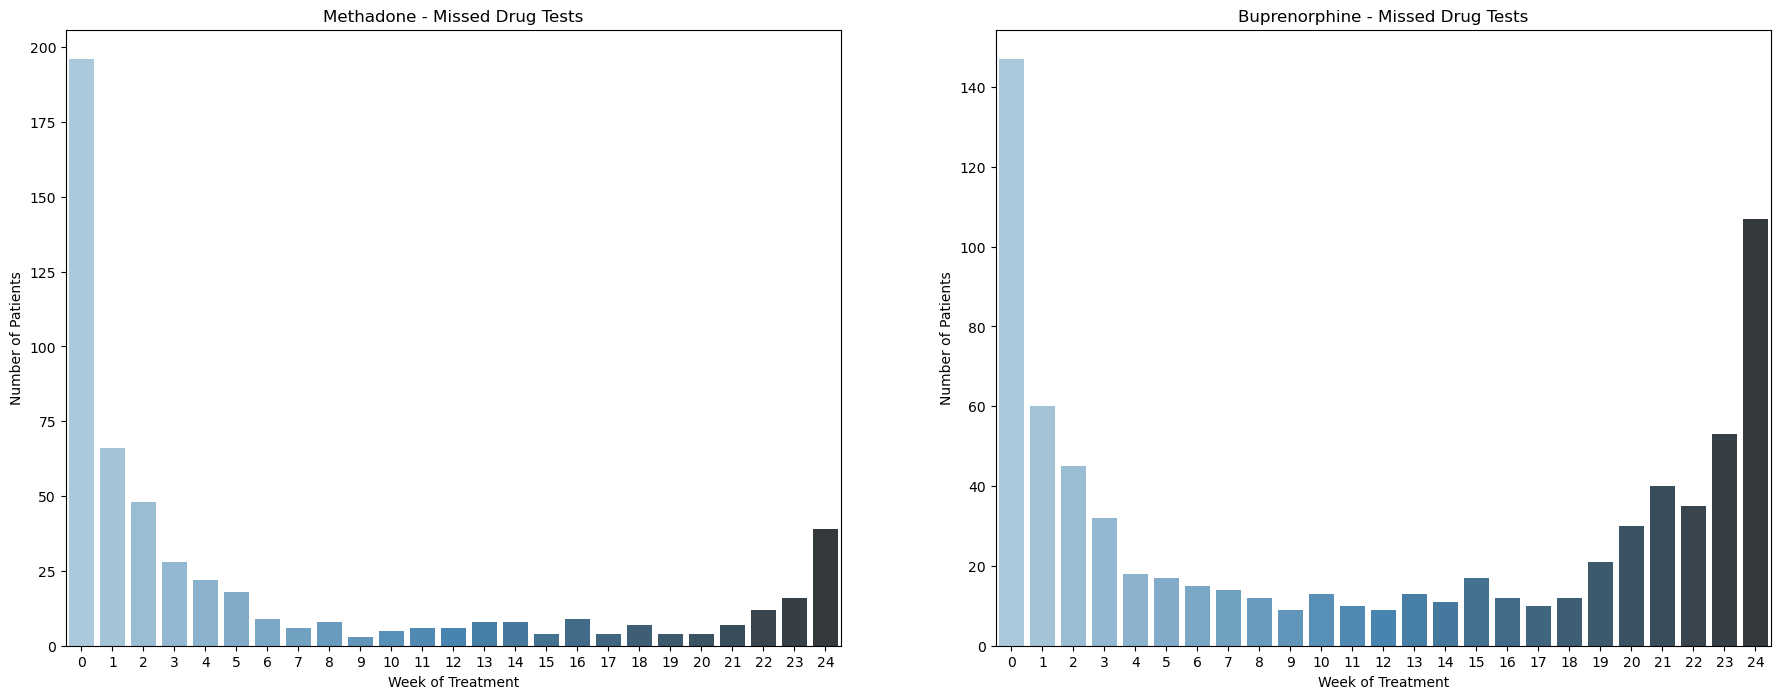

In [7]:
# create 2 plots next to eachother
fig, axes = plt.subplots(1, 2, figsize=(22, 8))


# plot no shows by medication by week
sns.countplot(x='missed_tests', data=med1, ax=axes[0], palette='Blues_d')
axes[0].set_title('Methadone - Missed Drug Tests')
axes[0].set_xlabel('Week of Treatment')
axes[0].set_ylabel('Number of Patients')

# plot no shows by medication by week
sns.countplot(x='missed_tests', data=med2, ax=axes[1], palette='Blues_d')
axes[1].set_title('Buprenorphine - Missed Drug Tests')
axes[1].set_xlabel('Week of Treatment')
axes[1].set_ylabel('Number of Patients')

plt.show()